Epoch [1/500], Loss: 39030099968.0000
Epoch [11/500], Loss: 39028162560.0000
Epoch [21/500], Loss: 39027527680.0000
Epoch [31/500], Loss: 39026999296.0000
Epoch [41/500], Loss: 39026491392.0000
Epoch [51/500], Loss: 39025987584.0000
Epoch [61/500], Loss: 39025491968.0000
Epoch [71/500], Loss: 39024992256.0000
Epoch [81/500], Loss: 39024504832.0000
Epoch [91/500], Loss: 39024017408.0000
Epoch [101/500], Loss: 39023525888.0000
Epoch [111/500], Loss: 39023050752.0000
Epoch [121/500], Loss: 39022563328.0000
Epoch [131/500], Loss: 39022088192.0000
Epoch [141/500], Loss: 39021608960.0000
Epoch [151/500], Loss: 39021129728.0000
Epoch [161/500], Loss: 39020650496.0000
Epoch [171/500], Loss: 39020179456.0000
Epoch [181/500], Loss: 39019700224.0000
Epoch [191/500], Loss: 39019225088.0000
Epoch [201/500], Loss: 39018754048.0000
Epoch [211/500], Loss: 39018274816.0000
Epoch [221/500], Loss: 39017803776.0000
Epoch [231/500], Loss: 39017328640.0000
Epoch [241/500], Loss: 39016853504.0000
Epoch [251/

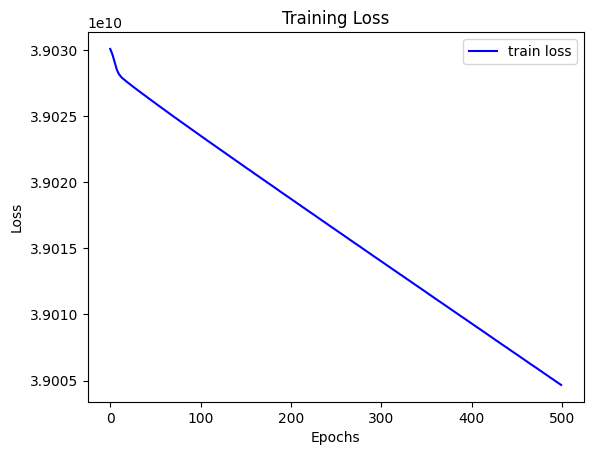

In [22]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

train_data_path ='./data/train.csv'
train = pd.read_csv(train_data_path)

num_of_train_data = train.shape[0]

test_data_path = './data/test.csv'
test = pd.read_csv(test_data_path)

# 房价，要拟合的目标值
target = train.SalePrice

# 输入特征，可以将SalePrice列扔掉
train.drop(['SalePrice'], axis=1, inplace=True)

# 将train和test合并到一起，一块进行特征工程，方便预测test的房价
combined = train.append(test)
combined.reset_index(inplace=True)
combined.drop(['index', 'Id'], inplace=True, axis=1)

# 选出非空列
def get_cols_with_no_nans(df, col_type):
    if col_type == 'num':
        predictors = df.select_dtypes(exclude=['object'])
    elif col_type == 'no_num':
        predictors = df.select_dtypes(include=['object'])
    elif col_type == 'all':
        predictors = df
    else:
        print('Error: choose a type (num, no_num, all)')
        return 0
    cols_with_no_nans = []
    for col in predictors.columns:
        if not df[col].isnull().any():
            cols_with_no_nans.append(col)
    return cols_with_no_nans

num_cols = get_cols_with_no_nans(combined, 'num')
cat_cols = get_cols_with_no_nans(combined, 'no_num')

# 过滤掉含有缺失值的特征
combined = combined[num_cols + cat_cols]

# 对分类特征进行One-Hot编码
def oneHotEncode(df, colNames):
    for col in colNames:
        if df[col].dtype == np.dtype('object'):
            # pandas.get_dummies 可以对分类特征进行One-Hot编码
            dummies = pd.get_dummies(df[col], prefix=col)
            df = pd.concat([df, dummies], axis=1)

            # drop the encoded column
            df.drop([col], axis=1, inplace=True)
    return df

combined = oneHotEncode(combined, cat_cols)

# 将combined中的每个元素转换为float类型
combined = combined.apply(lambda x: pd.to_numeric(x, errors='coerce'))

# 将所有特征缩放到[0, 1]区间
combined = (combined - combined.min()) / (combined.max() - combined.min())

# 训练数据集特征
train_features = combined[:num_of_train_data]
# 训练数据集目标
train_labels = target.values.reshape(-1, 1)
# 测试数据集特征
test_features = combined[num_of_train_data:]

# 将数据集转换成序列数据
def create_sequences(features, labels, sequence_length=5):
    xs = []
    ys = []

    for i in range(len(features) - sequence_length):
        x = features.iloc[i:(i+sequence_length)].values
        y = labels[i+sequence_length]
        xs.append(x)
        ys.append(y)
        
    xs = np.array(xs)
    ys = np.array(ys)
    
    return xs, ys

train_seq_features, train_seq_labels = create_sequences(train_features, train_labels)
test_seq_features, test_seq_labels = create_sequences(test_features, np.zeros((len(test_features), 1)))

# 定义RNN模型
class RNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers):
        super(RNN, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.rnn = nn.RNN(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        out, _ = self.rnn(x, h0.detach())
        out = self.fc(out[:, -1, :])
        return out

# 设置超参数
input_dim = train_seq_features.shape[2]
output_dim = 1
hidden_dim = 128
num_layers = 2
lr = 0.001
num_epochs = 500

# 初始化模型、损失函数以及优化器
model = RNN(input_dim, hidden_dim, output_dim, num_layers)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

# 记录训练过程的指标
train_losses = []

# 训练RNN模型
for epoch in range(num_epochs):
    # 前向传播
    outputs = model(torch.Tensor(train_seq_features))
    # 计算损失
    loss = criterion(outputs, torch.Tensor(train_seq_labels))
    # 反向传播及优化
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    train_losses.append(loss.item())

    # 每10轮输出一次损失
    if epoch % 10 == 0:
        print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, loss.item()))

# 绘制训练损失曲线
plt.plot(range(num_epochs), train_losses, 'b-', label='train loss')
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# 预测结果
test_seq_features_tensor = torch.from_numpy(test_seq_features).type(torch.Tensor)
y_pred = model(test_seq_features_tensor)
test_pred = y_pred.detach().numpy()

# 生成submission文件
submission = pd.DataFrame({'Id': test['Id'].values[:1454], 'SalePrice': test_pred.squeeze()})
submission.to_csv('submission.csv', index=False)
